In [1]:
import pandas as pd

In [2]:
air_quality = pd.read_csv('airquality_data.csv', encoding='cp1252')

C:\Users\hinge\AppData\Local\Temp\ipykernel_7704\3543136484.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  air_quality = pd.read_csv('airquality_data.csv', encoding='cp1252')


In [3]:
air_quality.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


### Data Cleaning

In [4]:
categorical_columns = ['sampling_date', 'state', 'location', 'agency', 'type', 'location_monitoring_station']

In [5]:
air_quality = air_quality.dropna(subset=['pm2_5'])


### Data integration

In [6]:
subSet1 = air_quality[['state', 'type']]

In [7]:
subSet2 = air_quality[['state','location']]

In [8]:
concat = pd.concat([subSet1, subSet2], axis=1)

In [9]:
concat.head()

,state,type,state,location
65036,Dadra & Nagar Haveli,Industrial Area,Dadra & Nagar Haveli,Khadoli
65037,Dadra & Nagar Haveli,Industrial Area,Dadra & Nagar Haveli,Khadoli
65038,Dadra & Nagar Haveli,Industrial Area,Dadra & Nagar Haveli,Khadoli
65039,Dadra & Nagar Haveli,Industrial Area,Dadra & Nagar Haveli,Khadoli
65040,Dadra & Nagar Haveli,Industrial Area,Dadra & Nagar Haveli,Khadoli


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Drop rows where target is missing
air_quality = air_quality.dropna(subset=['pm2_5'])

# Define input and output
X = air_quality[['stn_code', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station']]
y = air_quality['pm2_5']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Error Handling

In [13]:
def remove_outliers(column):
 Q1 = column.quantile(0.25)
 Q3 = column.quantile(0.75)
 IQR = Q3 - Q1
 threshold = 1.5 * IQR
 outlier_mask = (column < Q1 - threshold) | (column > Q3 + threshold)
 return column[~outlier_mask]

In [14]:
col_name = ['so2', 'no2', 'rspm', 'spm']

for col in col_name:
    air_quality[col] = pd.to_numeric(air_quality[col], errors='coerce')  # force strings to NaN

for col in col_name:
    air_quality[col] = remove_outliers(air_quality[col])


In [15]:
# Remove outliers for each column using a loop
col_name = ['so2', 'no2', 'rspm', 'spm']
for col in col_name:
 air_quality[col] = remove_outliers(air_quality[col])

### Data Transform

In [16]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns
col_label = ['state', 'location', 'type']

# Initialize LabelEncoder
encoder = LabelEncoder()

# Loop over selected categorical columns
for col in col_label:
    # Convert NaN to string 'Missing' (or another placeholder)
    air_quality[col] = air_quality[col].fillna('Missing')
    # Fit and transform the column
    air_quality[col] = encoder.fit_transform(air_quality[col])


### Model Building

In [17]:

from sklearn.ensemble import RandomForestRegressor

In [18]:
from sklearn.preprocessing import LabelEncoder

# Apply to all string columns
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)  # fit on both train+test
        le.fit(combined)

        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))


In [19]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
y_pred = model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

RMSE: 19.062562985776946


C:\Users\hinge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Data Visualixation

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
air_quality['date'] = pd.to_datetime(air_quality['date'], errors='coerce')

In [24]:
sns.set_theme(style="darkgrid")

In [25]:
state_pm25 = air_quality.groupby('state')['pm2_5'].mean().sort_values(ascending=False)

C:\Users\hinge\AppData\Local\Temp\ipykernel_7704\1485539313.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_pm25.index, y=state_pm25.values, palette='viridis')


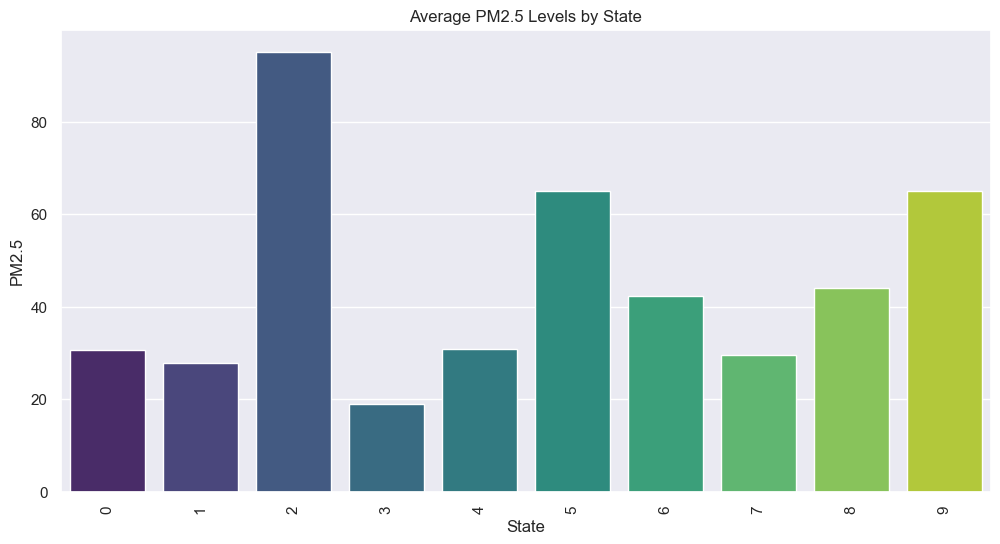

In [26]:
plt.figure(figsize=(12,6))
sns.barplot(x=state_pm25.index, y=state_pm25.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Average PM2.5 Levels by State')
plt.ylabel('PM2.5')
plt.xlabel('State')
plt.show()

C:\Users\hinge\AppData\Local\Temp\ipykernel_7704\4178308610.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=filtered, x='date', y='so2', ci=None)


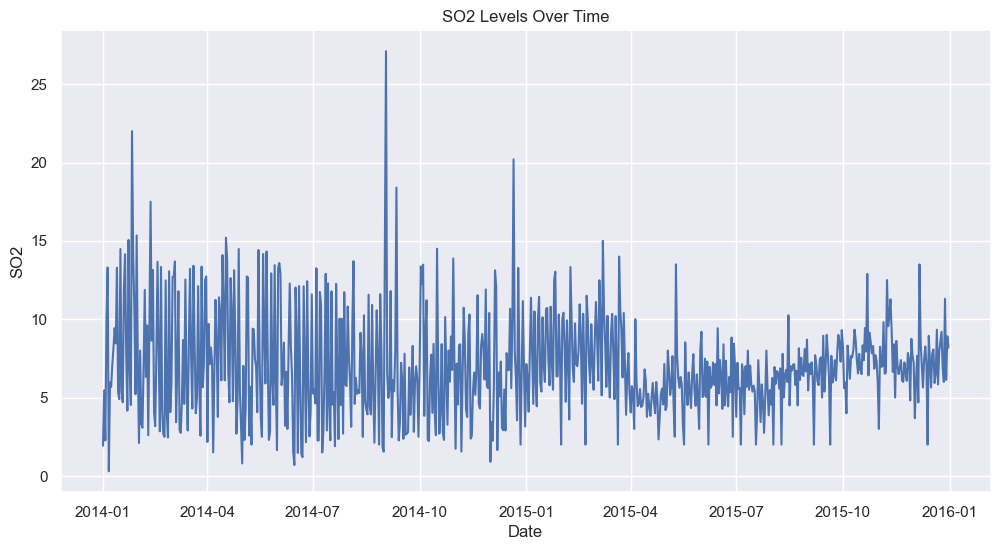

In [27]:
# Drop NaT values
filtered = air_quality.dropna(subset=['date', 'so2'])

# Line plot
plt.figure(figsize=(12,6))
sns.lineplot(data=filtered, x='date', y='so2', ci=None)
plt.title('SO2 Levels Over Time')
plt.ylabel('SO2')
plt.xlabel('Date')
plt.show()

C:\Users\hinge\AppData\Local\Temp\ipykernel_7704\436671250.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=air_quality, x='type', y='pm2_5', palette='coolwarm')


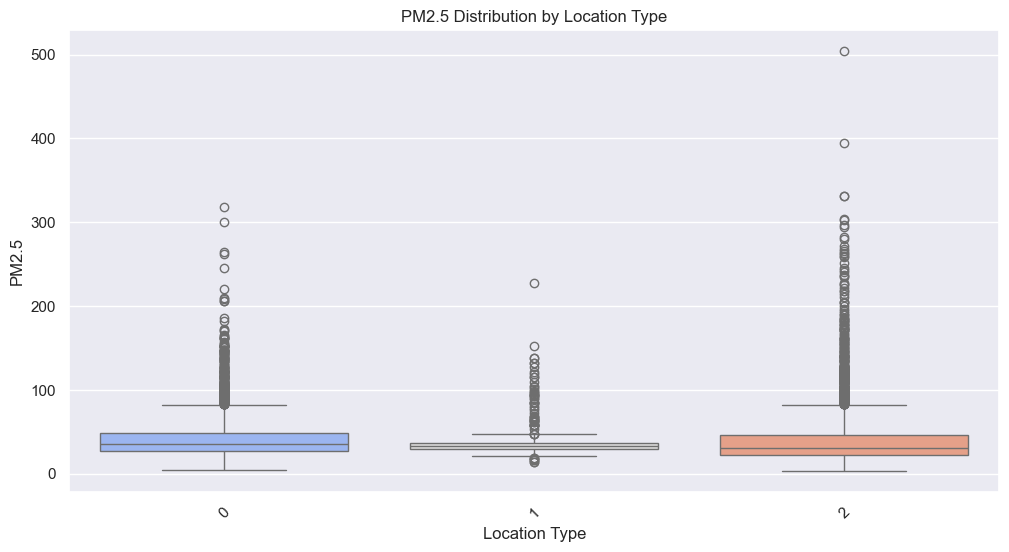

In [28]:
plt.figure(figsize=(12,6))
sns.boxplot(data=air_quality, x='type', y='pm2_5', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('PM2.5 Distribution by Location Type')
plt.ylabel('PM2.5')
plt.xlabel('Location Type')
plt.show()

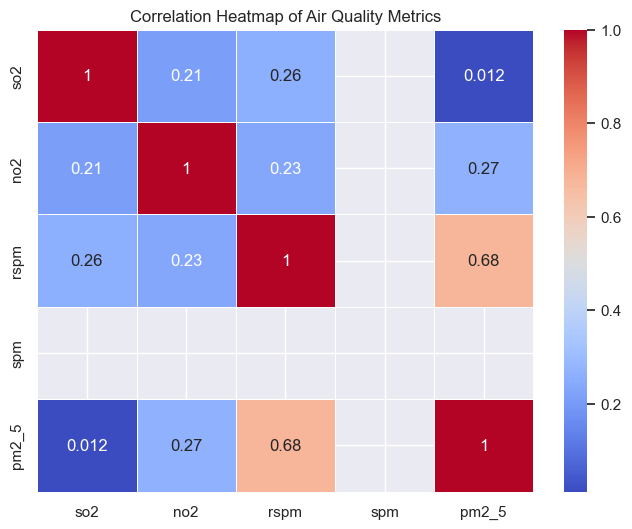

In [29]:
# Select numeric columns for pollution
pollutants = air_quality[['so2', 'no2', 'rspm', 'spm', 'pm2_5']]

# Calculate correlation matrix
correlation_matrix = pollutants.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Air Quality Metrics')
plt.show()
# Correlation Between Pollutants